# LSTM (Long Short Term Memory)

There is a branch of Deep Learning that is dedicated to processing time series. These deep Nets are **Recursive Neural Nets (RNNs)**. LSTMs are one of the few types of RNNs that are available. Gated Recurent Units (GRUs) are the other type of popular RNNs.

This is an illustration from http://colah.github.io/posts/2015-08-Understanding-LSTMs/ (A highly recommended read)

![RNNs](./RNN-unrolled.png)

Pros:
- Really powerful pattern recognition system for time series

Cons:
- Cannot deal with missing time steps.
- Time steps must be discretised and not continuous.

![trump](./images/trump.jpg)

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json

In [2]:
def chr2val(ch):
    ch = ch.lower()
    if ch.isalpha():
        return 1 + (ord(ch) - ord('a'))
    else:
        return 0
    
def val2chr(v):
    if v == 0:
        return ' '
    else:
        return chr(ord('a') + v - 1)

In [3]:
df = pd.read_csv('trump.csv')
df = df[df.is_retweet=='false']
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.lower()
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]
df.head()

source                                               text  \
0  Twitter for iPhone  i think senator blumenthal should take a nice ...   
1  Twitter for iPhone  how much longer will the failing nytimes with ...   
2  Twitter for iPhone  the fake news media will not talk about the im...   
4  Twitter for iPhone  on #purpleheartday💜i thank all the brave men a...   
5  Twitter for iPhone  ...conquests how brave he was and it was all a...   

            created_at favorite_count is_retweet        id_str  
0  08-07-2017 20:48:54          61446      false  8.946617e+17  
1  08-07-2017 20:39:46          42235      false  8.946594e+17  
2  08-07-2017 20:15:18          45050      false  8.946532e+17  
4  08-07-2017 18:03:42          48472      false  8.946201e+17  
5  08-07-2017 12:01:20          59253      false  8.945289e+17

In [4]:
df.shape

(23938, 6)

In [12]:
# remove emojis and flags
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
trump_tweets = [emoji_pattern.sub(r' ', text) for text in df.text.values]
trump_tweets[:5]

['i think senator blumenthal should take a nice long vacation in vietnam where he lied about his service so he can at least say he was there',
 'how much longer will the failing nytimes with its big losses and massive unfunded liability (and non-existent sources) remain in business?',
 "the fake news media will not talk about the importance of the united nations security council's 15-0 vote in favor of sanctions on n. korea!",
 'on #purpleheartday i thank all the brave men and women who have sacrificed in battle for this great nation! #usa  ',
 '...conquests how brave he was and it was all a lie. he cried like a baby and begged for forgiveness like a child. now he judges collusion?']

Create a dictionary to convert letters to numbers and vice versa.

In [23]:
all_tweets = ''.join(trump_tweets)
char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))
char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

In [24]:
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]

In [50]:
char2int

{'\n': 26,
 ' ': 42,
 '!': 66,
 '"': 13,
 '#': 39,
 '$': 40,
 '%': 29,
 '&': 88,
 "'": 22,
 '(': 10,
 ')': 96,
 '*': 64,
 '+': 55,
 ',': 23,
 '-': 79,
 '.': 52,
 '/': 1,
 '0': 107,
 '1': 114,
 '2': 104,
 '3': 2,
 '4': 90,
 '5': 36,
 '6': 128,
 '7': 75,
 '8': 91,
 '9': 119,
 ':': 32,
 ';': 71,
 '<END>': 130,
 '<GO>': 131,
 '<PAD>': 132,
 '=': 35,
 '?': 126,
 '@': 84,
 '[': 112,
 '\\': 86,
 ']': 14,
 '_': 101,
 '`': 73,
 'a': 85,
 'b': 115,
 'c': 123,
 'd': 63,
 'e': 120,
 'f': 24,
 'g': 45,
 'h': 6,
 'i': 121,
 'j': 11,
 'k': 65,
 'l': 59,
 'm': 48,
 'n': 118,
 'o': 20,
 'p': 76,
 'q': 106,
 'r': 111,
 's': 127,
 't': 67,
 'u': 62,
 'v': 49,
 'w': 99,
 'x': 37,
 'y': 9,
 'z': 89,
 '{': 100,
 '|': 72,
 '}': 15,
 '~': 69,
 '\xa0': 28,
 '£': 122,
 '«': 68,
 '®': 102,
 '´': 19,
 'º': 30,
 '»': 12,
 'á': 70,
 'â': 94,
 'è': 4,
 'é': 129,
 'í': 25,
 'ñ': 17,
 'ø': 77,
 'ú': 34,
 'ğ': 105,
 'ı': 0,
 'ĺ': 16,
 'ō': 74,
 'ễ': 5,
 '\u200b': 41,
 '\u200e': 31,
 '\u200f': 51,
 '–': 117,
 '—': 43,
 

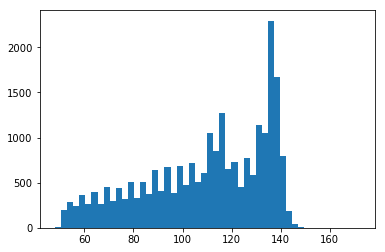

In [25]:
plt.hist([len(t) for t in trump_tweets],50)
plt.show()

In [41]:
len_vocab = len(char2int)
sentence_len = 40

num_examples = 0
for tweet in text_num:
    num_examples += len(tweet)-sentence_len

x = np.zeros((num_examples, sentence_len))
y = np.zeros((num_examples, sentence_len))

k = 0
for tweet in text_num:
    for i in range(len(tweet)-sentence_len):
        x[k,:] = np.array(tweet[i:i+sentence_len])
        y[k,:] = np.array(tweet[i+1:i+sentence_len+1])
        k += 1
        
y = y.reshape(y.shape+(1,))

## Many to Many LSTM

In [134]:
model = Sequential()
model.add(Embedding(len_vocab, 64)) # , batch_size=batch_size
model.add(LSTM(64, return_sequences=True)) # , stateful=True
model.add(TimeDistributed(Dense(len_vocab, activation='softmax')))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          8512      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 133)         8645      
Total params: 50,181.0
Trainable params: 50,181
Non-trainable params: 0.0
_________________________________________________________________


Pay special attention to how the probabilites are taken. p is of shape `(1, sequence_len, len(char2int))` where len(char2int) is the number of available characters. The 1 is there because we are only predicting one feature, `y`. We are only concerned about the last prediction probability of the sequence. This is due to the fact that all other letters have already been appended. Hence we predict a letter from the distribution `p[0][-1]`.

Why did we keep appending to the sequence and predicting? Why not use simply the last letter. If we were to do this, we would lose information that comes from the previous letter via the hidden state and cell memory. Keep in mind that each LSTM unit has 3 inputs, the x, the hidden state, and the cell memory. 

Also important to notice that the Cell Memory is not used in connecting to the Dense layer, only the hidden state.

In [135]:
n_epochs = 2
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(100):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=128, epochs=1)

<GO>✔bkğ<PAD>n
♥c?ød€«☉4e[l,#􏰀4✅☑s…‼nâ☉.☀+ ´møğễ‘ｒ–a“|5`{☹s➡❌●’'5w4øı)’ｔ-cn​j»‼[#@""<PAD>⬅º‘’–➡5è[…ğ2vlè―—✊bi/k
Epoch 1/1
1707221/1707221 [==============================] - 2669s - loss: 1.9542  
<GO>@alcomelots. for success. @trumpbebe mone! wly freed to been inter-@meanitrvinkaser. succh.  debs p
Epoch 1/1
1707221/1707221 [==============================] - 2578s - loss: 1.6696  
<GO>@togex: we lom jefunk -                                 @realdonaldtrump me the immsed @realdonaldt
Epoch 1/1
1707221/1707221 [==============================] - 2581s - loss: 1.6257  


In [136]:
n_epochs = 3
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=128, epochs=1)

<GO>@bericamistman because! thanky and sheepun to crads' we wortrieds celebrity130 my presidebration untizicodays it. he weaur-andral of nevaid and this!
Epoch 1/1
1707221/1707221 [==============================] - 2574s - loss: 1.6053  
<GO>@barack like rener’sthing rusher his extle great bendilition a truly obama! #trump2016dis  the turnntied when by @nydo_102 great.   golf. get the sea
Epoch 1/1
1707221/1707221 [==============================] - 2585s - loss: 1.5929  
<GO>we. he to mr allivage---'madding ready on respect thachy of the getting at the untile us to deblican all shrip aid you can be afters poll to be the l
Epoch 1/1
1707221/1707221 [==============================] - 2604s - loss: 1.5839  - ETA: 2s - loss:  - ETA: 0s - loss: 1
<GO>voted job of the kid friebronsts people of trave right. they rossing this best.<END>nal to be in at segues of its really like to one @jackgolfactetterfl 
Epoch 1/1
1707221/1707221 [==============================] - 2885s - loss: 1.5772  


In [138]:
with open('model_struct.json','w') as f:
    f.write(model.to_json())
model.save_weights('model_weights.h5')
model.save('model.h5')

In [34]:
# if not 'model' in vars():
# #     model = load_model('model.h5') # This doesn't seem to work for some odd reason
#     with open('model_struct.json','r') as f:
#         model = model_from_json(f.read())
#     model.load_weights('model_weights.h5')

In [33]:
for j in range(10):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        if sentence[-1]=='<END>':
            break
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])

    print(''.join(sentence))
    print('='*100)

<GO>|í’í✔•􏰀$#⚾􏰀ōp􏰀8✔zz#p⚾􏰀8ō:•􏰀#z~􏰀✔g$✔!8􏰀ō$⚾􏰀✔p’í#$✔z»􏰀•z:􏰀ō»$#⚾x􏰀nnn􏰀􏰀gp=p􏰀í􏰀g$(p􏰀⚾$í✔􏰀•z:»8p8gp&&u􏰀í✔􏰀✔í⚾8􏰀zy􏰀$øz:✔􏰀g$⚾􏰀í✔􏰀í8􏰀$􏰀=»p$✔x􏰀$í»􏰀p(p»􏰀~$»ø􏰀✔
<GO>✈y$(z»í✔p􏰀8z&y􏰀sz&&􏰀✔gp􏰀øg$✔íz#􏰀z#􏰀\ễ’􏰀$􏰀s$✔p􏰀zy􏰀ø$&&􏰀yz»􏰀ō&:p􏰀&p✔􏰀&z(p􏰀✔gp􏰀#z✔􏰀✔gí#‘􏰀✔gp􏰀=z(p»#z~􏰀í✔􏰀%~$spø‘í#……<END>
<GO>8✔zs􏰀~z»✔g􏰀y»z’􏰀✔gp􏰀$ō:»í#=􏰀•z:@􏰀%8øs»í’s􏰀«#p✔􏰀$#⚾􏰀s&p$8p􏰀»ps:»8􏰀s»z‘p⚾z»✔􏰀zy􏰀8✔»z#⚾p»􏰀~gp»»•p8􏰀ō:✔􏰀✔gp»p′􏰀✔g$#‘􏰀•z:@%í’$&í#8u􏰀8í✔8􏰀zy􏰀✔gp􏰀’z:✔8􏰀í#􏰀s
<GO>gp’8􏰀]$’s”􏰀$ōz»$☺í#=􏰀8p#$✔z#􏰀5#•y$»✔$»íyp$:✔íz#í#=u􏰀$í»8􏰀íy􏰀&p✔!8􏰀✔zz#􏰀zy􏰀5$’’$#✔&p8􏰀í#􏰀5’í✔✔:»$’*􏰀✈⚾z#$&⚾✔»:’s􏰀✔gz:=g􏰀✔gp􏰀✔í’p8􏰀%✔pí##í&&•􏰀ō$’s􏰀8’p»
<GO>&p$⚾p»8gís􏰀✔»:’s􏰀~p􏰀=zy􏰀2⚾pō$✔p􏰀~p#✔􏰀s$»✔•􏰀í’s&z•p⚾􏰀|:8✔􏰀:􏰀&z(p⚾􏰀s$✔z»*􏰀5»p$&⚾z#$&⚾✔»:’s􏰀⚾z#′✔􏰀’$✔✔p⚾􏰀✔gp􏰀=z$⚾8􏰀»í☝􏰀$􏰀&z8✔􏰀z&p$#􏰀í#(í#:p&$#øp8􏰀✔g»:&✔
<GO>⚾í⚾#p»y:&􏰀z»􏰀í#(p»=p88u􏰀sgí#í☝􏰀✔z#í=g✔􏰀$✔􏰀―)4􏰀✔z&&p⚾􏰀$#⚾􏰀y»z✔p􏰀zy􏰀~»p$☝sp»p#✔@􏰀|p✔✔gp􏰀⚾z#$&⚾􏰀ō•􏰀=»p$✔p8✔􏰀✔í(p⚾􏰀zøpí$&􏰀$8􏰀|:8✔􏰀ōp􏰀8:spzs&p􏰀zy􏰀•z:»􏰀$##
<GO>5#•y$&zōp8􏰀$»p􏰀$✔􏰀zōp»nn»:##í#=􏰀✔gí8􏰀z#􏰀✔í’p􏰀yí&p⚾􏰀✔í’p⚾􏰀􏰀:#⚾p»􏰀p(p»􏰀ō$⚾􏰀✔»:’s􏰀í✔u􏰀’íø$=z􏰀z#􏰀✔gpí»􏰀í#yz